In [1]:
library(magrittr)
library(DESeq2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGe

In [3]:
metaInfo <- read.table('/public/workspace/ryrl/FK/TCGA/RNA-seq/Meta/metaSub.txt', header = T, sep = '\t')
# metaInfo$Group <- factor(metaInfo$Group,levels = c('Tumor', 'Normal'))
# metaInfo$DataBase <- factor(metaInfo$DataBase,levels = c('TCGA', 'GTEx'))
head(metaInfo)

,Sample,Cancer,Group,DataBase
,<chr>,<chr>,<chr>,<chr>
1,TCGA-FU-A3HZ-01,CESC,Tumor,TCGA
2,TCGA-DR-A0ZM-01,CESC,Tumor,TCGA
3,TCGA-IR-A3LB-01,CESC,Tumor,TCGA
4,TCGA-DG-A2KJ-01,CESC,Tumor,TCGA
5,TCGA-C5-A7CM-01,CESC,Tumor,TCGA
6,TCGA-VS-A9UJ-01,CESC,Tumor,TCGA


In [4]:
unique(metaInfo['DataBase'])

,DataBase
,<chr>
1,TCGA


In [33]:
cancer <- 'BRCA'
dirs <- '/public/workspace/ryrl/projects/classmates/ryrl/Cancers/TCGA/'
metaSub <- metaInfo  # [metaInfo$Cancer == cancer,]
rownames(metaSub) <- metaSub$Sample
metaSub$Sample <- NULL
metaSub$Group_ <- ifelse(metaSub$Cancer == cancer, yes = cancer, no = 'Others')
metaSub$Group_ <- factor(x = metaSub$Group_, levels = c(cancer, 'Others'))
head(metaSub)

,Cancer,Group,DataBase,Group_
,<chr>,<chr>,<chr>,<fct>
TCGA-FU-A3HZ-01,CESC,Tumor,TCGA,Others
TCGA-DR-A0ZM-01,CESC,Tumor,TCGA,Others
TCGA-IR-A3LB-01,CESC,Tumor,TCGA,Others
TCGA-DG-A2KJ-01,CESC,Tumor,TCGA,Others
TCGA-C5-A7CM-01,CESC,Tumor,TCGA,Others
TCGA-VS-A9UJ-01,CESC,Tumor,TCGA,Others


In [34]:
unique(metaSub$Cancer)

[1] "CESC" "KIRP" "BRCA" "MESO" "GBM"  "COAD" "PAAD" "LIHC" "UCEC" "LUSC"
[11] "HNSC" "KICH" "LGG"  "UCS"  "ESCA" "READ" "UVM"  "BLCA" "ACC"  "PRAD"
[21] "KIRC" "LUAD" "PCPG" "DLBC" "OV"   "CHOL"

In [35]:
table(metaSub$Group_)


  BRCA Others 
  1098   7134 

In [36]:
# countData <- read.table(paste0(dirs, cancer, '.txt'), header = T, row.names = 1, sep = '\t', check.names = F) %>% as.matrix()
countData <- read.table(
    '/public/workspace/ryrl/projects/classmates/ryrl/Cancers/TCGA/intermediate/Counts.txt',
    header = T, row.names = 1, sep = '\t', check.names = F) %>% as.matrix()
countData <- countData[grep('ENSG', x = rownames(countData)),]
# metaSub <- metaSub[match(colnames(countData), rownames(metaSub)),]  # match the order of metaSub and countData, ref=countData
head(countData)

,TCGA-FU-A3HZ-01,TCGA-DR-A0ZM-01,TCGA-IR-A3LB-01,TCGA-DG-A2KJ-01,TCGA-C5-A7CM-01,TCGA-VS-A9UJ-01,TCGA-VS-A8QH-01,TCGA-MY-A5BF-01,TCGA-JW-A5VJ-01,TCGA-C5-A1BN-01,⋯,TCGA-W5-AA38-01,TCGA-4G-AAZO-01,TCGA-ZD-A8I3-01,TCGA-W5-AA2O-01,TCGA-ZH-A8Y6-01,TCGA-W6-AA0S-01,TCGA-W5-AA33-01,TCGA-YR-A95A-01,TCGA-W5-AA2I-01,TCGA-W5-AA34-01
ENSG00000000003,3423,2162,10190,462,5349,2661,4561,1884,1582,1869,⋯,8249,1631,5254,2883,576,3632,11342,10086,4245,8150
ENSG00000000005,0,0,6,0,1,0,36,2,0,0,⋯,1,0,1,0,0,1,1,10,0,0
ENSG00000000419,1952,1275,3556,708,2574,984,3249,3402,1878,3553,⋯,1696,757,1212,1491,1314,1486,976,1273,788,1770
ENSG00000000457,613,878,1270,112,611,621,436,604,1185,1316,⋯,519,1535,753,1017,1384,558,1538,1026,714,1202
ENSG00000000460,459,339,912,47,494,273,337,834,603,1868,⋯,297,162,370,358,254,185,390,166,307,378
ENSG00000000938,210,719,323,91,177,74,115,350,401,81,⋯,182,137,143,248,103,570,668,151,118,223


In [37]:
length(unique(metaSub$DataBase))

[1] 1

In [38]:
dim(countData)

[1] 60483  8232

In [39]:
table(rownames(metaSub) == colnames(countData))


TRUE 
8232 

In [40]:
table(metaSub$DataBase)


TCGA 
8232 

In [41]:
table(metaSub['Group'])


Tumor 
 8232 

In [42]:
dim(metaSub)

[1] 8232    4

In [43]:
table(metaSub$Group_)


  BRCA Others 
  1098   7134 

In [58]:
dds <- DESeqDataSetFromMatrix(
    countData = countData,
    colData = metaSub,
    design = ~ Cancer # ~ DataBase + Group
    # tidy = T
)
dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 60483 8232 
metadata(1): version
assays(1): counts
rownames(60483): ENSG00000000003 ENSG00000000005 ... ENSGR0000280767
  ENSGR0000281849
rowData names(0):
colnames(8232): TCGA-FU-A3HZ-01 TCGA-DR-A0ZM-01 ... TCGA-W5-AA2I-01
  TCGA-W5-AA34-01
colData names(4): Cancer Group DataBase Group_

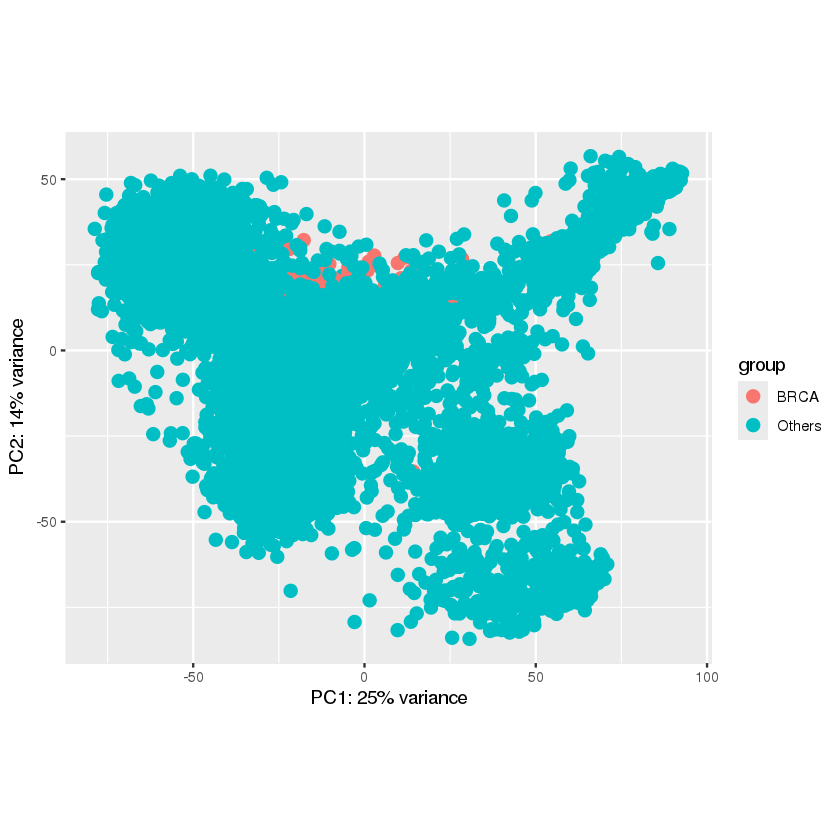

In [48]:
vsd <- vst(dds, blind = F)
plotPCA(vsd, intgroup = "Group_")  # The plot indicates the batch effect is significant

In [59]:
smallestGroupSize <- .5
keep <- rowSums(counts(dds) > 0) / ncol(countData) >= smallestGroupSize
dds <- dds[keep,]

In [60]:
# dds$Group <- relevel(dds$Cancer, ref = cancer)
# dds$Group

In [61]:
dds <- DESeq(dds)
# res <- results(dds)
res

estimating size factors

estimating dispersions

gene-wise dispersion estimates



In [ ]:
res <- results(dds, contrast=c("Group_", cancer,"Others"), pAdjustMethod = 'fdr', parallel = F, tidy = T)
colnames(res)[1] <- 'EnsembleID'
head(res)

ERROR: Error in results(dds, contrast = c("Group_", cancer, "Others"), pAdjustMethod = "fdr", : couldn't find results. you should first run DESeq()


In [28]:
# cancer <- stringr::str_split_fixed(string = file, pattern = '\\.', n = 2)[,1]
res$Cancer <- cancer
head(res)

,EnsembleID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Cancer
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSG00000000003,5711.992183,0.4448232,0.2494266,1.783383,7.452401e-02,1.284886e-01,BLCA
2,ENSG00000000005,6.828814,-1.2062691,0.6157452,-1.959039,5.010819e-02,9.198708e-02,BLCA
3,ENSG00000000419,2100.071081,0.3953938,0.1114555,3.547549,3.888332e-04,1.385160e-03,BLCA
4,ENSG00000000457,884.164792,0.3003760,0.1375030,2.184505,2.892514e-02,5.787166e-02,BLCA
5,ENSG00000000460,649.518455,1.5212719,0.2059862,7.385311,1.520976e-13,3.701954e-12,BLCA
6,ENSG00000000938,603.648850,-0.2948087,0.2501134,-1.178700,2.385177e-01,3.340684e-01,BLCA


In [100]:
cancer

[1] "BLCA"

In [101]:
readr::write_tsv(res, file = paste0('/public/workspace/ryrl/FK/TCGA/', cancer, '.txt'), col_names = T)

In [2]:
readRDS('/public/workspace/ryrl/projects/classmates/ryrl/Cancers/TCGA/intermediate/dds_cancer.rds') -> dds

In [9]:
table(dds$Group_)


  BRCA Others 
  1098   7134 